In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_style('whitegrid')

In [3]:
file1 = "Loan_known_data.csv"

ChunkSize = 100000
i = 1
for chunk in pd.read_csv(file1, chunksize=ChunkSize):
    df_LC = chunk if i == 1 else pd.concat([df_LC, chunk])
    print('-->Read Chunk...', i)
    i += 1


-->Read Chunk... 1
-->Read Chunk... 2
-->Read Chunk... 3
-->Read Chunk... 4
-->Read Chunk... 5
-->Read Chunk... 6
-->Read Chunk... 7
-->Read Chunk... 8
-->Read Chunk... 9
-->Read Chunk... 10
-->Read Chunk... 11


In [4]:
df_LC.dtypes

loan_amnt                  int64
term                      object
int_rate                 float64
installment              float64
grade                     object
emp_title                 object
emp_length                 int64
home_ownership            object
annual_inc               float64
verification_status       object
loan_status               object
purpose                   object
addr_state                object
dti                      float64
delinq_2yrs              float64
initial_list_status       object
open_acc_6m              float64
open_act_il              float64
open_il_12m              float64
il_util                  float64
open_rv_12m              float64
inq_fi                   float64
inq_last_12m             float64
acc_open_past_24mths     float64
mort_acc                 float64
num_accts_ever_120_pd    float64
num_tl_op_past_12m       float64
tot_hi_cred_lim          float64
total_bal_ex_mort        float64
total_bc_limit           float64
year      

In [5]:
df_LC.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'dti', 'delinq_2yrs',
       'initial_list_status', 'open_acc_6m', 'open_act_il', 'open_il_12m',
       'il_util', 'open_rv_12m', 'inq_fi', 'inq_last_12m',
       'acc_open_past_24mths', 'mort_acc', 'num_accts_ever_120_pd',
       'num_tl_op_past_12m', 'tot_hi_cred_lim', 'total_bal_ex_mort',
       'total_bc_limit', 'year', 'percent_complete', 'max_bal_bc_cat',
       'num_sats_cat', 'percent_bc_gt_75_cat'],
      dtype='object')

### Finding the correlation between variables ###
We will now look at the correlation structure between our variables that we selected above. This will tell us about any dependencies between different variables and help us reduce the dimensionality a little bit more

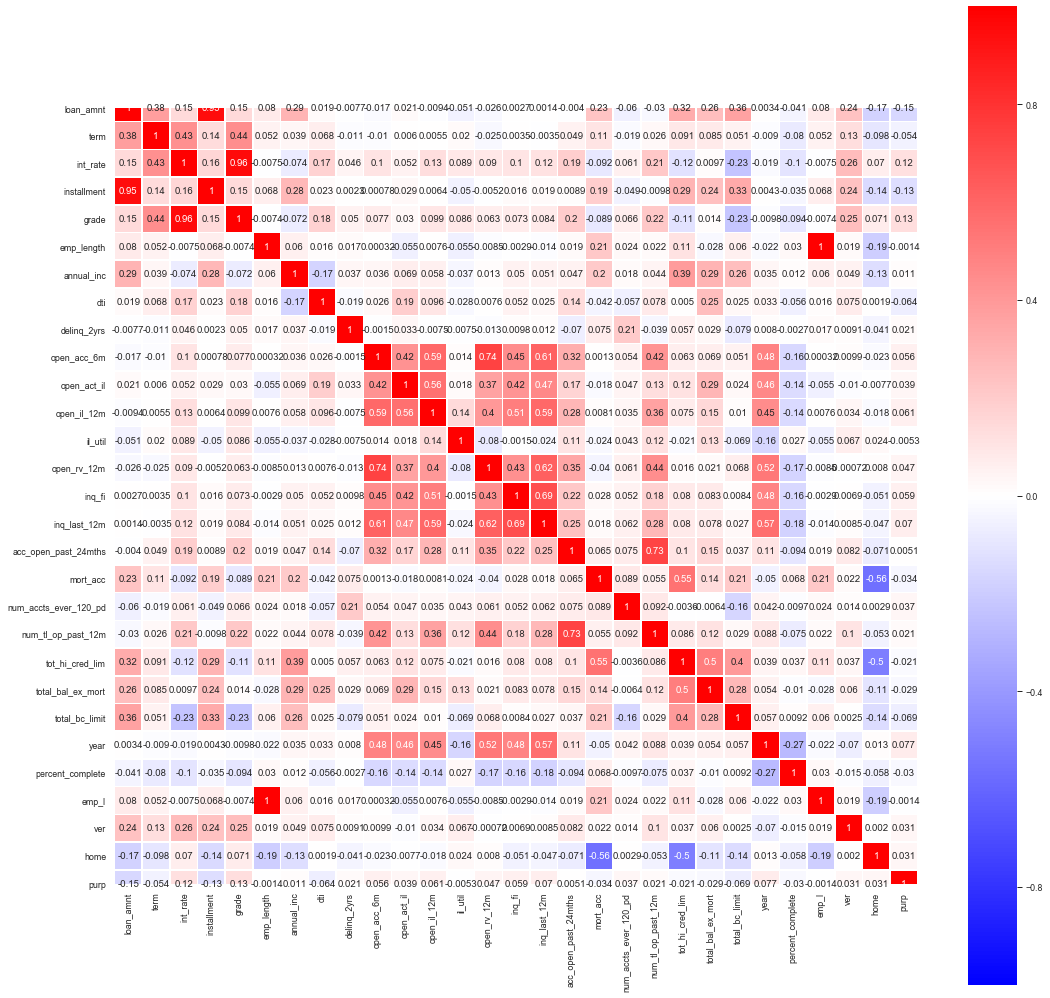

In [10]:
plt.figure(figsize=(18,18))
sns.set_context("paper", font_scale=1)
##finding the correllation matrix and changing the categorical data to category for the plot.
sns.heatmap(df_LC.assign(grade=df_LC.grade.astype('category').cat.codes,
                         term=df_LC.term.astype('category').cat.codes,
                        emp_l=df_LC.emp_length.astype('category').cat.codes,
                         ver =df_LC.verification_status.astype('category').cat.codes,
                        home=df_LC.home_ownership.astype('category').cat.codes,
                        purp=df_LC.purpose.astype('category').cat.codes).corr(), 
                         annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=0.5)

We will now encode the two categories listed above as 0 or 1 for our analysis. This will help us in predicting whether a person defaulted their loan or not. 0 means he deaulted and 1 means he paid off his loan.

In [11]:
df_LC.loan_status=df_LC.loan_status.astype('category').cat.codes
# df_LC.delinq_2yrs=df_LC.delinq_2yrs.astype('category').cat.codes
# df_LC.head()
df_LC['loan_status'].value_counts()

1    851566
0    234046
Name: loan_status, dtype: int64

It can be seen from the plot above that loan amount and installment have a very high correlation amongst each other (0.94). This is intuitive since a person who takes a large sum of loan would require extra time to repay it back. Also, interest rate, sub grade and grade have a very high correlation between them. This is obvious since interest rate is decided by grades once the grades are decided, a subgrade is assigned to that loan (leading to high correlation).

Let's drop the three categories alongwith term and verification status(since it doesn't provide any valuable info) for further analysis.

In [12]:
df_LC = df_LC.drop(['emp_title', 'initial_list_status', 'percent_complete', 'year']
           , axis=1)

In [13]:


purpose_dict = {'debt_consolidation': 'debt_consolidation', 'credit_card': 'credit_card', 'house' : 'home_improvement' ,\
                'car' : 'major_purchase', 'other': 'other',  'moving' : 'other', 'vacation' : 'other',\
                'small_business' : 'other', 'renewable_energy' : 'other', 'wedding' : 'other', 'educational' : 'other', \
               'home_improvement':'home_improvement', 'medical': 'medical', 'major_purchase':'major_purchase', }


In [14]:
df_LC['purpose'] = df_LC['purpose'].map(purpose_dict)
# df_LC['purpose'].map(purpose_dict)

In [15]:
df_LC.purpose.unique()
print(df_LC.head(10))

   loan_amnt        term  int_rate  installment grade  emp_length  \
0      30000   36 months     22.35      1151.16     D           5   
1      40000   60 months     16.14       975.71     C           0   
2      20000   36 months      7.56       622.68     A          10   
3       4500   36 months     11.31       147.99     B          10   
4       8425   36 months     27.27       345.18     E           3   
5      20000   60 months     17.97       507.55     D           4   
6       6600   36 months     11.31       217.05     B          10   
7       2500   36 months     13.56        84.92     C           5   
8       4000   36 months     17.97       144.55     D           5   
9       2700   36 months      8.19        84.85     A           4   

  home_ownership  annual_inc verification_status  loan_status  \
0       MORTGAGE    100000.0     Source Verified            1   
1       MORTGAGE     45000.0            Verified            1   
2       MORTGAGE    100000.0        Not Verif

21


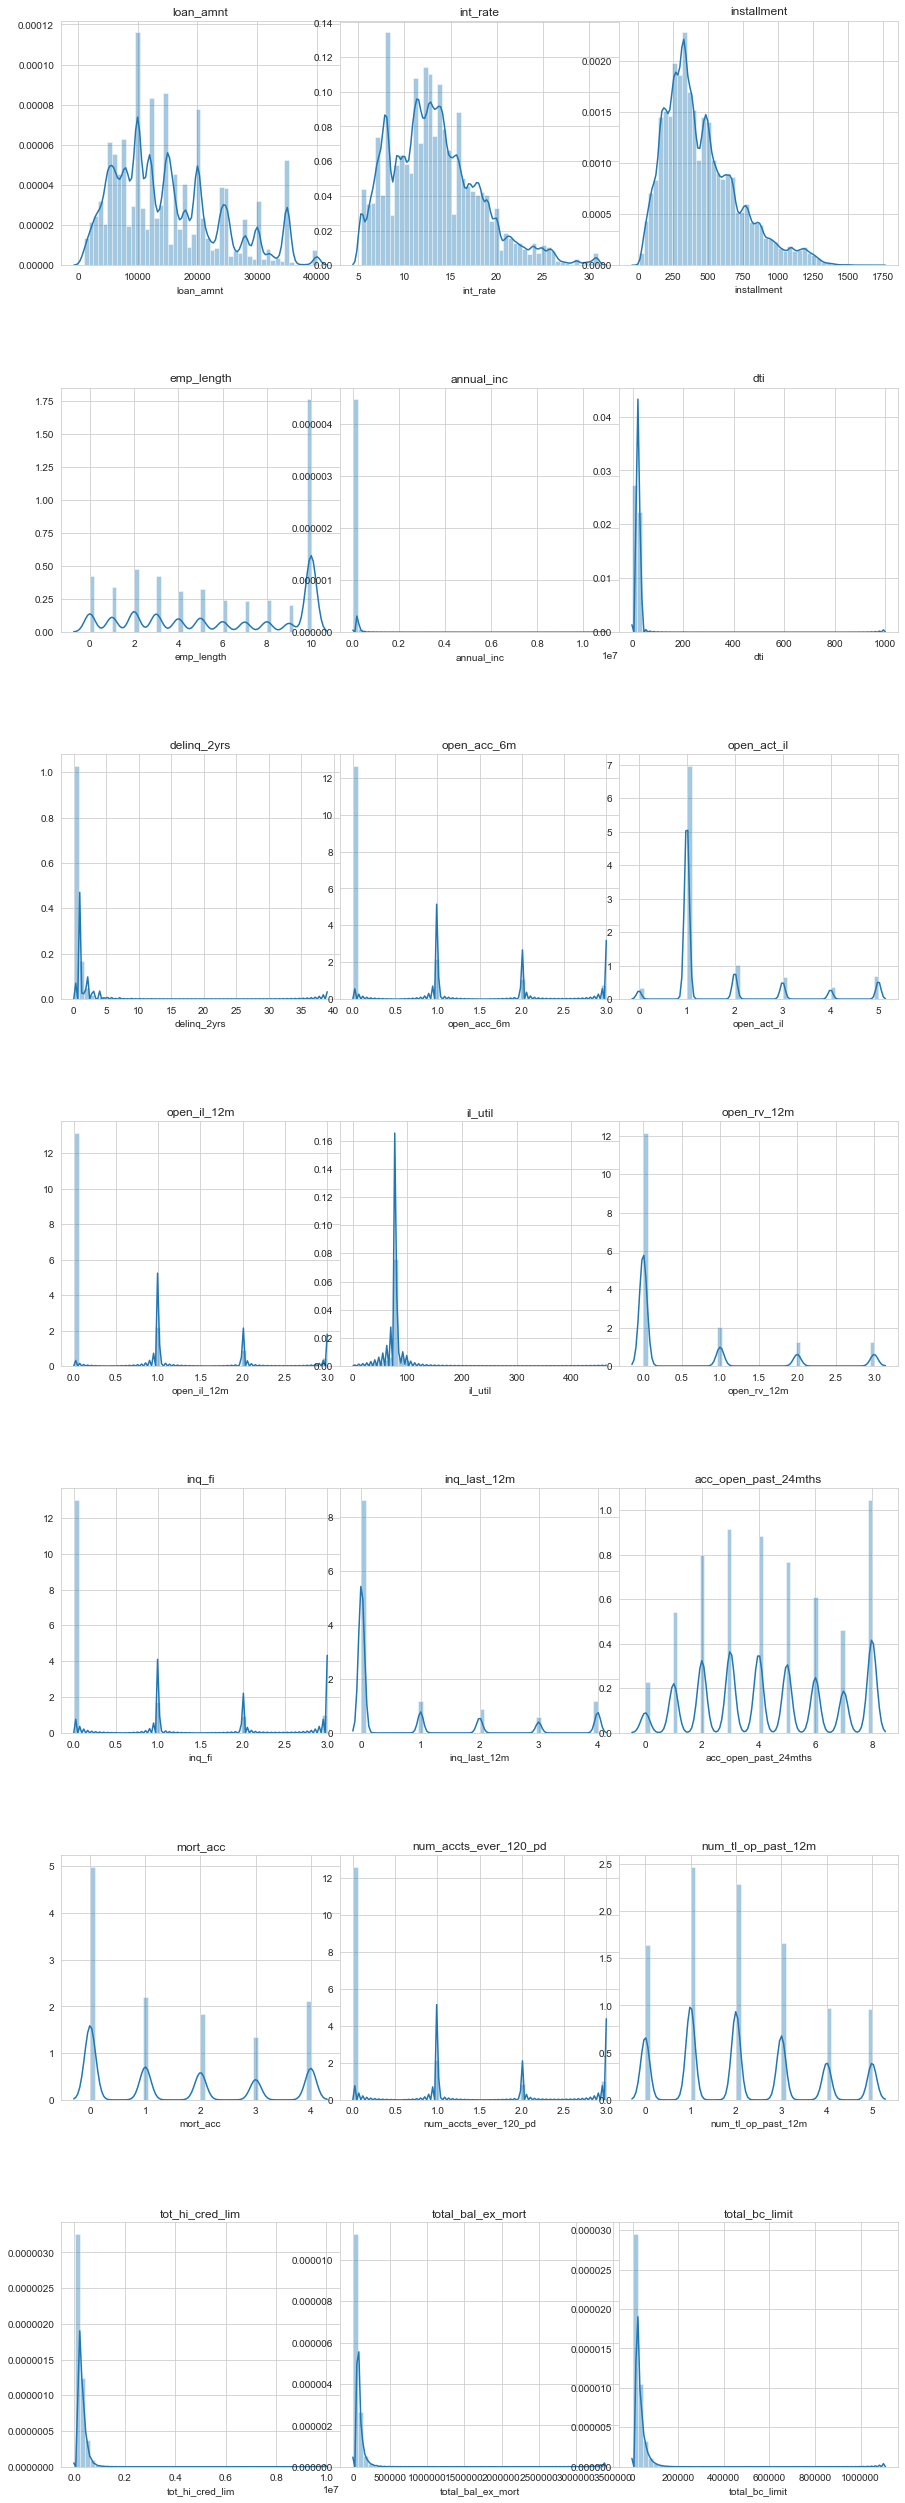

In [8]:
numerical = df_LC.columns[(df_LC.dtypes == 'float64') | (df_LC.dtypes == 'int64')].tolist()
print(len(numerical))
fig, axs = plt.subplots(7,3, figsize=(15, 45), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i, c in enumerate(numerical):
    sns.distplot(df_LC[c], ax= axs[i])
    axs[i].set_title(c)
    


In [16]:
df_LC.inq_fi.value_counts(normalize=True)

0.0    0.779631
1.0    0.103461
3.0    0.061441
2.0    0.055466
Name: inq_fi, dtype: float64

In [17]:
df_LC.total_bal_ex_mort.max()

3408095.0

In [18]:

df_LC['annual_inc_cat'] = pd.cut(x=df_LC['annual_inc'], bins=[0, 20000, 45000, 65000, 80000 ,130000, 50000000],\
                                    include_lowest=True)

# print(df_LC[['annual_inc', 'annual_inc_cat']].head())

df_LC['delinq_2yrs_cat'] = np.where(df_LC['delinq_2yrs']> 0, 'yes', 'no')
# df_LC['delinq_2yrs_cat'] = 'no'
# df_LC.loc[df_LC['delinq_2yrs']> 0,'delinq_2yrs_cat'] = 'yes'

df_LC['num_accts_ever_120_pd_cat'] = np.where(df_LC['num_accts_ever_120_pd']> 0, 'yes', 'no')

# df_LC['num_accts_ever_120_pd_cat'] = 'no'
# df_LC.loc[df_LC['num_accts_ever_120_pd']> 0,'num_accts_ever_120_pd_cat'] = 'yes'

df_LC['open_il_12m_cat'] = np.where(df_LC['open_il_12m']> 0, 'yes', 'no')
# df_LC['open_il_12m_cat'] = 'no'
# df_LC.loc[df_LC['open_il_12m']> 0,'open_il_12m_cat'] = 'yes'

df_LC['open_rv_12m_cat'] = np.where(df_LC['open_rv_12m']> 0, 'yes', 'no')
# df_LC['open_rv_12m_cat'] = 'no'
# df_LC.loc[df_LC['open_rv_12m']> 0,'open_rv_12m_cat'] = 'yes'

df_LC['inq_last_12m_cat'] = np.where(df_LC['inq_last_12m']> 0, 'yes', 'no')
# df_LC['inq_last_12m_cat'] = 'no'
# df_LC.loc[df_LC['inq_last_12m']> 0,'inq_last_12m_cat'] = 'yes'

df_LC['acct_ratio'] = df_LC['open_acc_6m'] / df_LC['acc_open_past_24mths']


In [131]:
features = ['loan_amnt', 'term', 'grade','emp_length', 'home_ownership', 'annual_inc_cat',\
            'verification_status', 'purpose', 'dti', 'delinq_2yrs_cat', 'inq_last_12m_cat', \
            'acct_ratio', 'loan_status', 'mort_acc', 'num_accts_ever_120_pd_cat',  'open_act_il', 'open_il_12m_cat', \
           'il_util', 'open_rv_12m_cat', 'tot_hi_cred_lim',  'total_bal_ex_mort',  'total_bc_limit']
mc = df_LC[features]

In [132]:
# mc = df_LC[['loan_amnt', 'term', 'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc',\
#             'verification_status', 'loan_status', 'purpose', 'addr_state']]

print(mc.head())

   loan_amnt        term grade  emp_length home_ownership  \
0      30000   36 months     D           5       MORTGAGE   
1      40000   60 months     C           0       MORTGAGE   
2      20000   36 months     A          10       MORTGAGE   
3       4500   36 months     B          10           RENT   
4       8425   36 months     E           3       MORTGAGE   

           annual_inc_cat verification_status             purpose    dti  \
0     (80000.0, 130000.0]     Source Verified  debt_consolidation  30.46   
1      (20000.0, 45000.0]            Verified         credit_card  50.53   
2     (80000.0, 130000.0]        Not Verified         credit_card  18.92   
3      (20000.0, 45000.0]        Not Verified         credit_card   4.64   
4  (130000.0, 50000000.0]            Verified         credit_card  12.37   

  delinq_2yrs_cat inq_last_12m_cat  acct_ratio  loan_status  mort_acc  \
0              no              yes        0.25            1       1.0   
1              no             

### One Hot Encoding ###
Since we have some categorical variables for the analysis and the machne learning algorithms doesn't take categorical and string variables directly, we have to creat dummy variables for them. We can either encode them using label encoder available for python, but it would be wrong in our analysis since a lot of these variables have multiple categories. Just using weights can cause discrepencies in the algorithm. Instead, we will one hot encode these so that we have a 1 wherever that category turns up and 0 otherwise. This will also create seperate columns for each level of category. Also, we'll be dropping one of the categories so that we have N-1 columns instead of N.

In [133]:
print(mc.shape)




# Drop any residual missing value (only 24)
mc = mc.dropna(axis=0, how = 'any')
print(mc.shape)
mc.dtypes
mc.dtypes[(mc.dtypes == 'object') | (mc.dtypes == 'category')].index.to_list()

(1085612, 22)
(1046281, 22)


['term',
 'grade',
 'home_ownership',
 'annual_inc_cat',
 'verification_status',
 'purpose',
 'delinq_2yrs_cat',
 'inq_last_12m_cat',
 'num_accts_ever_120_pd_cat',
 'open_il_12m_cat',
 'open_rv_12m_cat']

In [134]:
# mc_copy = mc.copy()
cat_features = mc.dtypes[(mc.dtypes == 'object') | (mc.dtypes == 'category')].index.to_list()
for c in cat_features:
    mc[c] = mc[c].astype('category').cat.codes

In [135]:
mc.head()

,loan_amnt,term,grade,emp_length,home_ownership,annual_inc_cat,verification_status,purpose,dti,delinq_2yrs_cat,inq_last_12m_cat,acct_ratio,loan_status,mort_acc,num_accts_ever_120_pd_cat,open_act_il,open_il_12m_cat,il_util,open_rv_12m_cat,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit
0,30000,0,3,5,1,4,1,1,30.46,0,1,0.25,1,1.0,0,3.0,1,75.0,0,527120.0,98453.0,28600.0
1,40000,1,2,0,1,1,2,0,50.53,0,1,0.40,1,1.0,0,5.0,1,87.0,1,344802.0,161720.0,45700.0
2,20000,0,0,10,1,4,0,0,18.92,0,0,0.20,1,4.0,0,2.0,0,71.0,1,622183.0,71569.0,85100.0
3,4500,0,1,10,5,1,0,0,4.64,0,1,0.25,1,0.0,1,1.0,1,100.0,1,53795.0,29137.0,15100.0
4,8425,0,4,3,1,5,2,0,12.37,0,1,0.00,1,4.0,0,5.0,1,70.0,1,768304.0,189194.0,45800.0


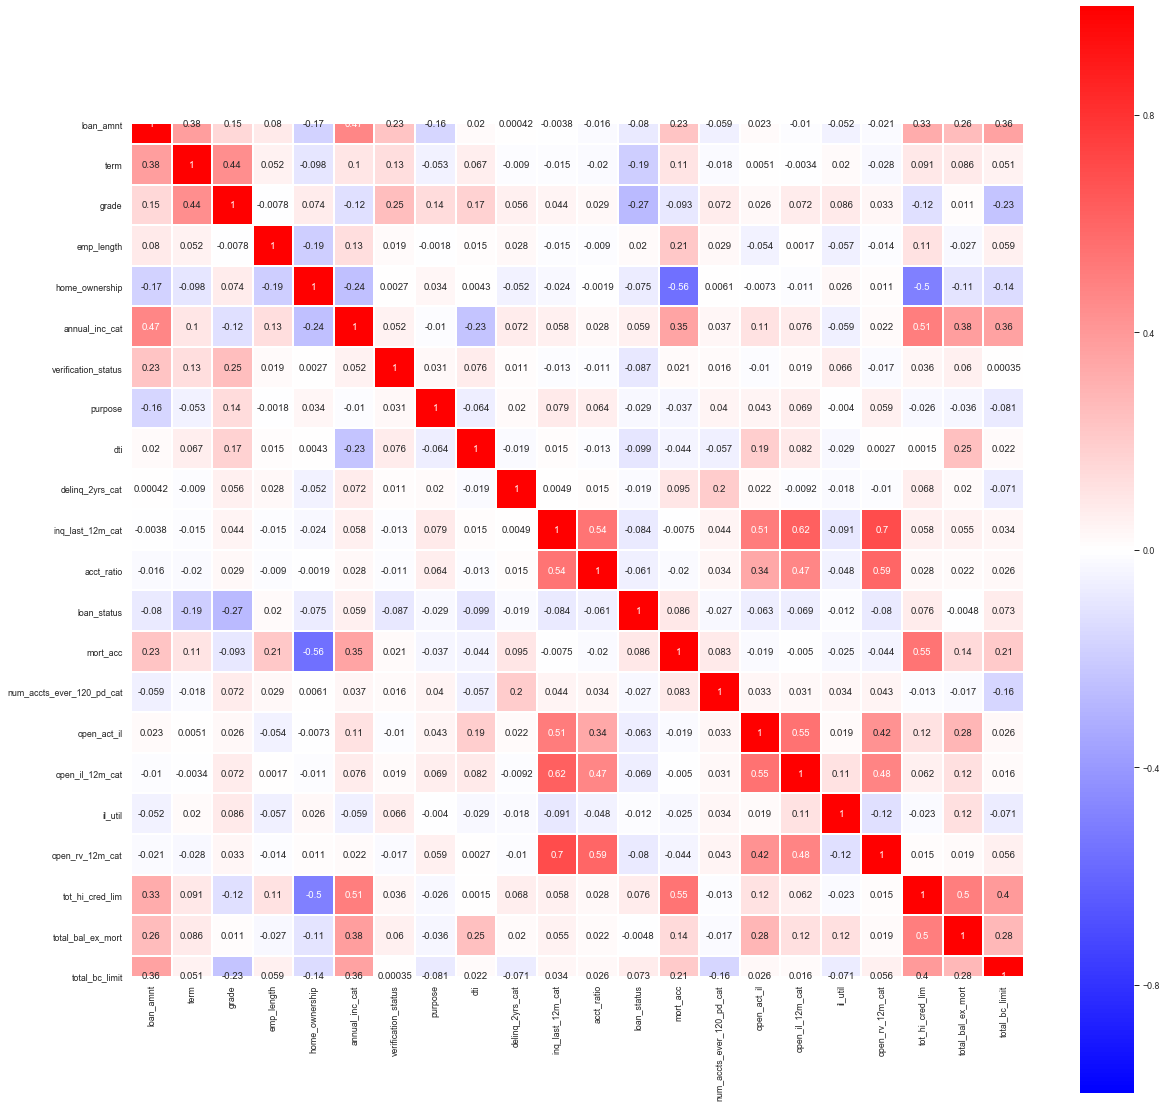

In [136]:
plt.subplots(figsize = (20,20))
sns.heatmap(mc_copy.corr(), annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=1)

In [137]:
mc.dtypes

loan_amnt                      int64
term                            int8
grade                           int8
emp_length                     int64
home_ownership                  int8
annual_inc_cat                  int8
verification_status             int8
purpose                         int8
dti                          float64
delinq_2yrs_cat                 int8
inq_last_12m_cat                int8
acct_ratio                   float64
loan_status                     int8
mort_acc                     float64
num_accts_ever_120_pd_cat       int8
open_act_il                  float64
open_il_12m_cat                 int8
il_util                      float64
open_rv_12m_cat                 int8
tot_hi_cred_lim              float64
total_bal_ex_mort            float64
total_bc_limit               float64
dtype: object

In [138]:

cat_features = mc.dtypes[(mc.dtypes == 'object') | (mc.dtypes == 'category')].index.to_list()
mcdata = pd.get_dummies(mc, columns=cat_features, drop_first = True).astype(float)
# y = X_clean['target']

(1046281, 22)


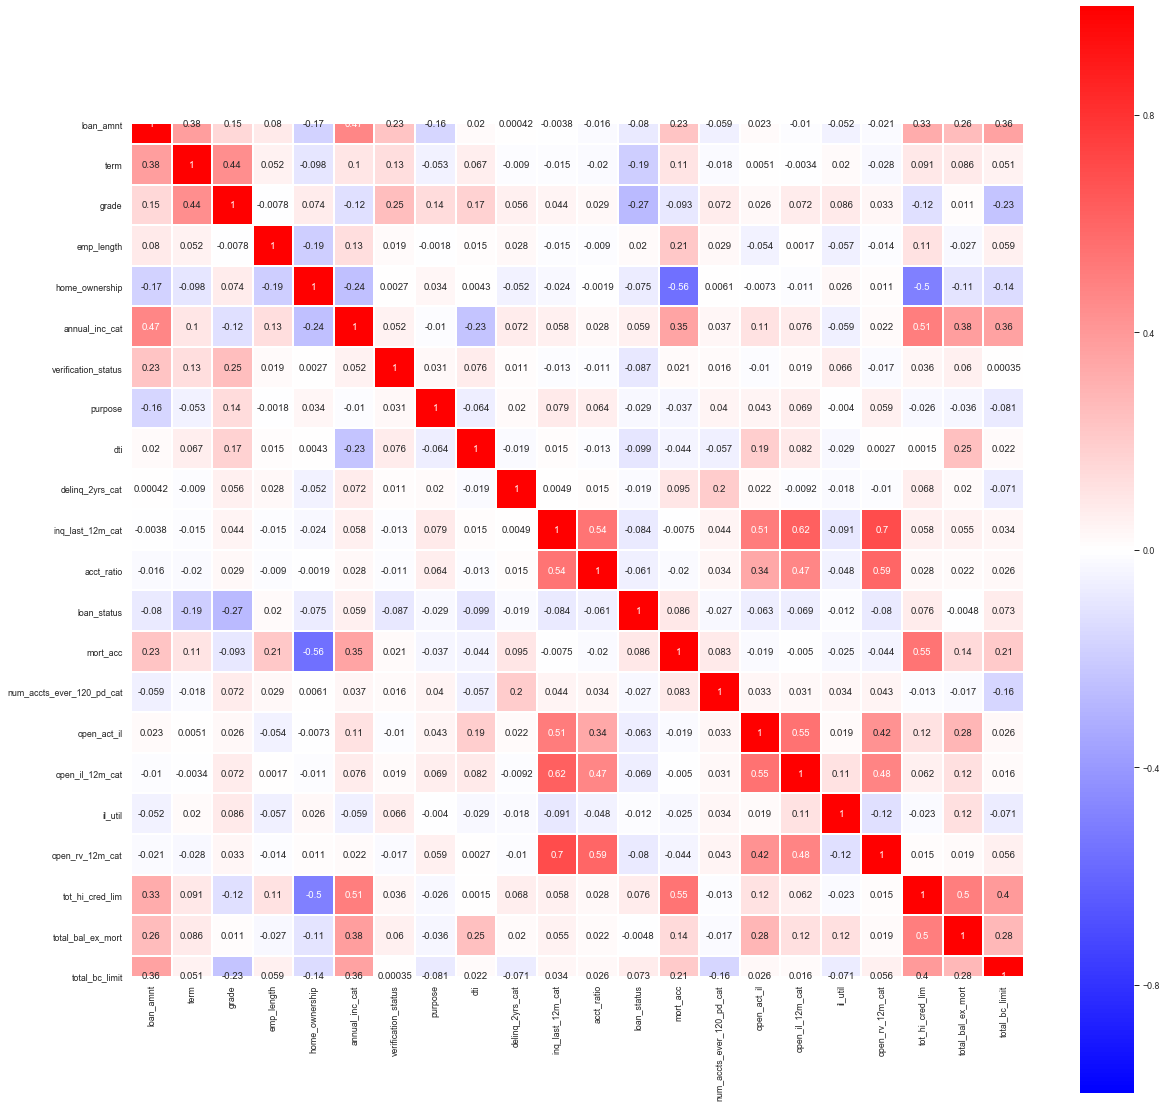

In [139]:
print(mcdata.shape)
mcdata.head()
plt.subplots(figsize = (20,20))
sns.heatmap(mcdata.corr(), annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=1)

Now splitting the data using scikitlearn's train_test_split and using 60% data for training and 40% for testing.

We'll now scale the data so that each column has a mean of zero and unit standard deviation. Xunb (unbalanced set) and yunb are the independent and target variable.

### Model Selection ###
We are now ready to build some models. The following would be our approach for building and selecting the best model:

* Build a model on the imbalance dataset we got from data cleaning.
* Balance the dataset by using equal amount of default and 'fully paid' loans.
#### Trying the Unbalanced Dataset ####
Let's first try the unbalanced dataset.The function below computes the receiver operating characteristic (ROC) curves for each of the models. This function will be called later in the analysis.

In [140]:
def print_report(test_y, test_predict):
    from sklearn.metrics import confusion_matrix
    
    
    print(confusion_matrix(test_y, test_predict))

    from sklearn.metrics import classification_report
    print(classification_report(test_y, test_predict))

# def prepare_regression_data(load_existing=False):
#     if load_existing:
#         import numpy as np
#         dataset = np.load('regression_annual_dataset.npz')
#         return (dataset['arr_0'], dataset['arr_1'], dataset['arr_2'], dataset['arr_3'])

In [141]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [142]:
# from sklearn.neighbors import KNeighborsClassifier
LABEL_COL = 'loan_status'
# sc = StandardScaler()
X = mcdata.loc[:, mcdata.columns != LABEL_COL]
y = mcdata.loc[:, mcdata.columns == LABEL_COL]

# X_train, X_test, y_train, y_test = train_test_split(X ,y , test_size = 0.3, random_state = 42)
# train, test = np.split(mcdata.sample(frac=1), [int(.8*len(mcdata))])

# X_train = train.loc[:, train.columns[:10]].values
# y_train = train.loc[:, train.columns == LABEL_COL].values.squeeze()
# X_test = test.loc[:, test.columns[:10]].values
# y_test = test.loc[:, test.columns == LABEL_COL].values.squeeze()

# X_scaled = preprocessing.scale(X)
# print(X_scaled)
# print('   ')
# print(X_scaled.shape)

X_train, X_test, y_train, y_test = train_test_split(X ,y , test_size = 0.3, random_state = 42)

In [143]:
y.head()

,loan_status
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [144]:
# Import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# # Setup the hyperparameter grid
# c_space = np.logspace(-5, 8, 15)
# train_accuracy = np.empty(len(c_space))
# test_accuracy = np.empty(len(c_space))
# for i, c in enumerate(c_space):
#     print(i)
#     logreg = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000, C = c)
#     logreg.fit(X_train, y_train)
#     train_accuracy[i] = logreg.score(X_train, y_train)
#     test_accuracy[i] = logreg.score(X_test, y_test)
    



[0.10187002 0.02900372 0.06474469 0.07050942 0.01796634 0.04184757
 0.02249971 0.0457459  0.10979415 0.01318668 0.00797312 0.02880927
 0.03071711 0.01260678 0.02762627 0.00859445 0.04054701 0.00778042
 0.10609932 0.10510225 0.1069758 ]


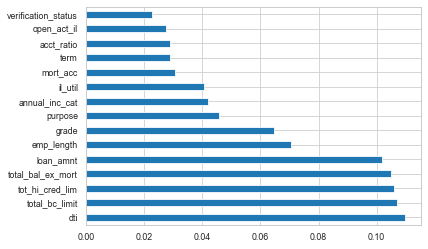

In [145]:
import pandas as pd
import numpy as np
# data = pd.read_csv("D://Blogs//train.csv")
# X = data.iloc[:,0:20]  #independent columns
# y = data.iloc[:,-1]    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X.values,y.values.ravel())
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [105]:
# print(test_accuracy)
# plt.title('Log Reg: Varying Number of C')
# plt.plot(c_space, test_accuracy, label = 'Testing Accuracy')
# plt.plot(c_space, train_accuracy, label = 'Training Accuracy')
# plt.legend()
# plt.xlabel('Number of C')
# plt.ylabel('Accuracy')
# plt.show()

In [106]:
from sklearn.linear_model import LogisticRegression

print('Fitting logistic regression model...')
log_reg = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train.ravel())

print('\nResults on train:')
print_report(y_train, log_reg.predict(X_train))

print('\nResults on test:')
print_report(y_test, log_reg.predict(X_test))

Fitting logistic regression model...

Results on train:
[[108274  51723]
 [205655 366744]]
              precision    recall  f1-score   support

         0.0       0.34      0.68      0.46    159997
         1.0       0.88      0.64      0.74    572399

    accuracy                           0.65    732396
   macro avg       0.61      0.66      0.60    732396
weighted avg       0.76      0.65      0.68    732396


Results on test:
[[ 46055  22205]
 [ 88408 157217]]
              precision    recall  f1-score   support

         0.0       0.34      0.67      0.45     68260
         1.0       0.88      0.64      0.74    245625

    accuracy                           0.65    313885
   macro avg       0.61      0.66      0.60    313885
weighted avg       0.76      0.65      0.68    313885



In [96]:
# print('Fitting SGDClassifier...')
# from sklearn.linear_model import SGDClassifier
# sgd = SGDClassifier(class_weight='balanced', loss='squared_hinge', tol=1e-5, max_iter=10000)
# sgd.fit(X_train, y_train.ravel())

# print('\nResults on train:')
# print_report(y_train, sgd.predict(X_train))

# print('\nResults on test:')
# print_report(y_test, sgd.predict(X_test))

In [97]:
# print('Fitting Random Forest...')
# from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=30, max_features=20)
# clf.fit(X_train, y_train.ravel())

# print('\nResults on train:')
# print_report(y_train, clf.predict(X_train))

# print('\nResults on test:')
# print_report(y_test, clf.predict(X_test))

In [98]:
from imblearn.over_sampling import SMOTE

# index_split = int(len(X)/2)
# X_train, y_train = SMOTE().fit_sample(X_scaled[0:index_split, :], y[0:index_split])
# X_test, y_test = X_scaled[index_split:], y[index_split:]

sm = SMOTE(random_state=42)
X, y = sm.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X ,y , test_size = 0.3, random_state = 42)

In [99]:
from sklearn.linear_model import LogisticRegression

print('Fitting logistic regression model...')
log_reg = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)
log_reg.fit(X_train, y_train.ravel())

print(round(log_reg.score(X_test, y_test) * 100, 2), '%')

print('\nResults on train:')
print_report(y_train, log_reg.predict(X_train))

print('\nResults on test:')
print_report(y_test, log_reg.predict(X_test))

Fitting logistic regression model...
58.6 %

Results on train:
[[342730 229531]
 [243438 329534]]
              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59    572261
         1.0       0.59      0.58      0.58    572972

    accuracy                           0.59   1145233
   macro avg       0.59      0.59      0.59   1145233
weighted avg       0.59      0.59      0.59   1145233


Results on test:
[[146863  98900]
 [104273 140779]]
              precision    recall  f1-score   support

         0.0       0.58      0.60      0.59    245763
         1.0       0.59      0.57      0.58    245052

    accuracy                           0.59    490815
   macro avg       0.59      0.59      0.59    490815
weighted avg       0.59      0.59      0.59    490815



In [59]:
print('Fitting SGDClassifier...')
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(class_weight='balanced', loss='squared_hinge', tol=1e-5, max_iter=10000)
sgd.fit(X_train, y_train.ravel())

print(round(sgd.score(X_test, y_test) * 100, 2), '%')

print('\nResults on train:')
print_report(y_train, sgd.predict(X_train))

print('\nResults on test:')
print_report(y_test, sgd.predict(X_test))

Fitting SGDClassifier...
54.15 %

Results on train:
[[553923  18338]
 [507197  65775]]
              precision    recall  f1-score   support

         0.0       0.52      0.97      0.68    572261
         1.0       0.78      0.11      0.20    572972

    accuracy                           0.54   1145233
   macro avg       0.65      0.54      0.44   1145233
weighted avg       0.65      0.54      0.44   1145233


Results on test:
[[237861   7902]
 [217127  27925]]
              precision    recall  f1-score   support

         0.0       0.52      0.97      0.68    245763
         1.0       0.78      0.11      0.20    245052

    accuracy                           0.54    490815
   macro avg       0.65      0.54      0.44    490815
weighted avg       0.65      0.54      0.44    490815



In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the list classifiers
# Set seed for reproducibility
SEED=1

# Instantiate lr
lr = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)

# Instantiate knn
sgd = SGDClassifier(class_weight='balanced', loss='squared_hinge', tol=1e-5, max_iter=10000)
      
# Instantdeciate dt
dt = DecisionTreeClassifier(min_samples_leaf=0.13, random_state=SEED)

classifiers = [('Logistic Regression', lr), ('Gradient', sgd), ('Classification Tree', dt)]
# Instantiate a VotingClassifier vc
vc = VotingClassifier(estimators=classifiers)     

# Fit vc to the training set
vc.fit(X_train, y_train)   

print('\nResults on train:')
print_report(y_train, vc.predict(X_train))

print('\nResults on test:')
print_report(y_test, vc.predict(X_test))

### Conclusion
We have successfully built an machine learning algorithm to predict the people who might default on their loans. This can be further used by LendingClub for their analysis. Also, we might want to look on other techniques or variables to improve the prediction power of the algorthm. One of the drawbacks is just the limited number of people who defaulted on their loan in the 8 years of data (2007-2015) present on the dataset. We can use an updated dataframe which consist next 3 years values (2015-2018) and see how many of the current loans were paid off or defaulted or even charged off. Then these new data points can be used for predicting them or even used to train the model again to improve its accuracy.

Since we had a lot of categorical data, we cannot apply PCA for dimensionality reduction. Because of this, we can try some different type of variable selection method like 'MULTIPLE CORRESPONDENCE ANALYSIS' to reduce the dimensionality and select the most important variables from the columns.

Since the algorithm puts around 47% of non-defaulters in the default class, we might want to look further into this issue to make the model more robust.